In [67]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate

In [68]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file


In [69]:
scaling_interface = ol.scaling_interface_0

In [148]:
# how much do you scale by?
scaling_interface.write(0x00, 16)

In [142]:
N = 4096
num_width = 32

In [72]:
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [73]:
dma_prn_data = ol.dma_prn_data
dma_prn_config = ol.dma_prn_config
dma_iq_data = ol.dma_iq_data
dma_iq_config = ol.dma_iq_config
dma_ifft_config = ol.dma_ifft_config
dma_res_data = ol.dma_output

In [116]:
# # testing with 2 waves of same frequency, known convolution
# iq_data = allocate(N, dtype=np.uint32)
# prn_data = allocate(N, dtype=np.uint32)
# full_data = allocate(2*N, dtype=np.uint32)
# for i in range(N):
#     iq_data[i] = get_value_from_complex(np.cos(i*2*np.pi/N) * 0x7FFF, np.sin(i*2*np.pi/N) * 0x7FFF, num_width // 2)
#     prn_data[i] = 0x00FF0000 if i<100 else 0
# #     prn_data[i] = get_value_from_complex(np.cos(i*2*np.pi/N) * 0x7FFF, np.sin(i*2*np.pi/N) * 0x7FFF, num_width // 2)
# #     iq_data[i] = get_value_from_complex(np.random.randint(-0x7FFF, 0x7FFF), np.random.randint(-0x7FFF, 0x7FFF), num_width // 2)
# #     prn_data[i] = get_value_from_complex(np.random.randint(-0x7FFF, 0x7FFF), np.random.randint(-0x7FFF, 0x7FFF), num_width // 2)
#     full_data[2*i] = iq_data[i]
#     full_data[2*i+1] = prn_data[i]
# res_data = allocate(2*N, dtype=np.uint32)

In [182]:
# test with real data
def decode_complex_numbers(filename):
    # Read the binary data from the file
    with open(filename, 'rb') as f:
        data = f.read()
    
    int16_data = np.frombuffer(data, dtype='>i2')
    
    # Check if the data length is correct (should be 4096 complex numbers, i.e., 8192 bytes)
    if len(int16_data) != 8192:
        raise ValueError(f"Unexpected file size. Expected 8192 bytes, but got {len(int16_data)} bytes.")
    
    # Split the data into real and imaginary parts
    real_part = int16_data[0::2]  # Every other element starting from index 0
    imag_part = int16_data[1::2]  # Every other element starting from index 1
    
    return real_part, imag_part

# Usage example
filename = "out-1208-4096-sample-8ms.dat"
real, imag = decode_complex_numbers(filename)
iq_data = allocate(N, dtype=np.uint32)
doppler = -10400
for i in range(N):
    x = real[i]
    y = imag[i]
    val = (x+y*1j) * np.exp(-1j*2*np.pi*doppler*i/4096/1000)
    iq_data[i] = get_value_from_complex(val.real, val.imag, num_width//2)
# we expect 0x0006ffff here
hex(iq_data[0])

'0x6ffff'

In [183]:
with open('ca.mem', 'r') as f:
    data = [1 if line == '7fff\n' else -1 for line in f]
arr = np.array(data)
assert arr.size == N  * 37, f"Expected 4096 * 37 values, but got {arr.size}"
reshaped_arr = arr.reshape(37, N)
print(reshaped_arr.shape)  # Should print (37, 4096)

(37, 4096)


In [184]:
# we think PRN 6 works well with Doppler shift -10400

In [185]:
prn_6 = reshaped_arr[5, :]

In [186]:
prn_6[:20] # should start with seven 1's

array([ 1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,
        1,  1, -1])

In [187]:
prn_data = allocate(N, dtype=np.uint32)
for i in range(N):
    prn_data[i] = get_value_from_complex(prn_6[i] * 0x7fff, 0, num_width//2)
hex(prn_data[0])

'0x7fff0000'

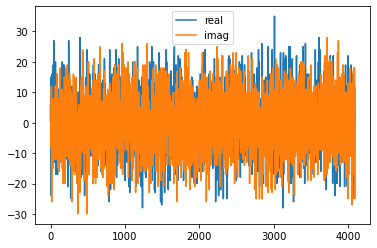

In [188]:
iq_data_components = get_components(iq_data, num_width // 2)
plt.plot(list(range(N)), iq_data_components['real'], label='real')
plt.plot(list(range(N)), iq_data_components['imag'], label='imag')
plt.legend()

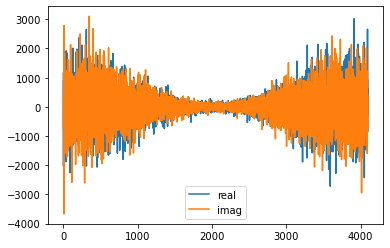

In [189]:
iq_fft = np.fft.fft(iq_data_components['real'] + iq_data_components['imag']*1j)
plt.plot(list(range(N)), iq_fft.real, label='real')
plt.plot(list(range(N)), iq_fft.imag, label='imag')
plt.legend()

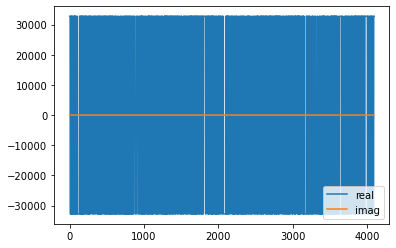

In [190]:
prn_data_components = get_components(prn_data, num_width // 2)
plt.plot(list(range(N)), prn_data_components['real'], label='real')
plt.plot(list(range(N)), prn_data_components['imag'], label='imag')
plt.legend()

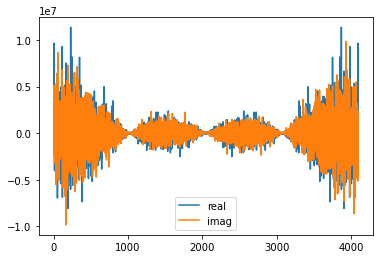

In [191]:
prn_fft = np.fft.fft(prn_data_components['real'] + prn_data_components['imag']*1j)                    
plt.plot(list(range(N)), prn_fft.real, label='real')
plt.plot(list(range(N)), prn_fft.imag, label='imag')
plt.legend()

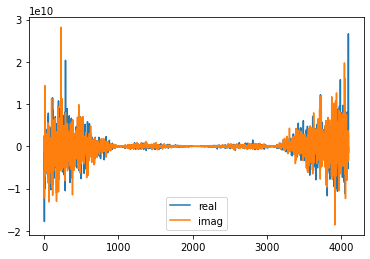

In [192]:
predicted_prod = iq_fft * prn_fft.conj()      
plt.plot(list(range(N)), predicted_prod.real, label='real')
plt.plot(list(range(N)), predicted_prod.imag, label='imag')
plt.legend()

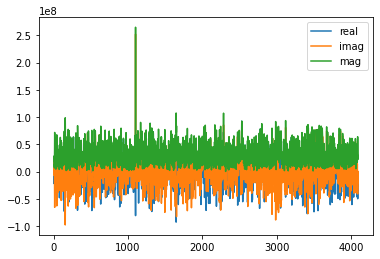

In [193]:
predicted_res = np.fft.ifft(iq_fft * prn_fft.conj())                   
plt.plot(list(range(N)), predicted_res.real, label='real')
plt.plot(list(range(N)), predicted_res.imag, label='imag')
plt.plot(list(range(N)), np.abs(predicted_res), label='mag')
plt.legend()

In [194]:
# send configs to ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1

In [195]:
# # note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
dma_ifft_config.sendchannel.transfer(ifft_config)
dma_ifft_config.sendchannel.wait()

In [196]:
dma_iq_data.sendchannel.transfer(iq_data)
dma_iq_data.sendchannel.wait()

In [197]:
dma_prn_data.sendchannel.transfer(prn_data)
dma_prn_data.sendchannel.wait()

In [198]:
dma_res_data.recvchannel.transfer(res_data)
dma_res_data.recvchannel.wait()

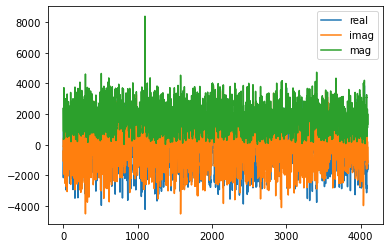

In [199]:
# 64 bit imprecision
real = res_data[1::2]
imag = res_data[0::2]
real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]

plt.plot(list(range(N)), real_decimal, label='real')
plt.plot(list(range(N)), imag_decimal, label='imag')
plt.plot(list(range(N)), [np.sqrt(r**2+i**2) for (r, i) in zip(real_decimal, imag_decimal)], label='mag')
plt.legend()